# Lab 9 - Convolutional Neural Networks

In this lab you'll use [PyTorch](https://pytorch.org/) to train a *convolutional neural network* (CNN, or ConvNet) on synthetic and real data, and to inspect both the filters and the feature maps of your model to ensure you understand the inner workings (intermediate representations) that are computed during the feed-forward computation of a ConvNet.

**Run the code cell below** to import the required packages.

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import warnings
np.set_printoptions(precision=3, suppress=True)  # Print array values as 0.0023 instead of 2.352e-3
torch.set_printoptions(precision=3, sci_mode=False)

**Run the code cell below** to define a plotting function that is useful for visualizing the weights of neural networks and images.

In [169]:
def plot_matrix_grid(V, cmap='bwr'):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    The default cmap is "bwr" (blue-white-red) but can also be "gray".
    """
    if isinstance(V, torch.Tensor):
        V = V.detach().numpy()
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmax = np.percentile(np.abs(V), [99.9])      # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap(cmap))
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axes.flat[len(V):]:
        ax.set_axis_off()
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right    

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Convolutional Neural Networks on Synthetic Data

Exercise 1.1&ndash;1.4 ask you to generate a synthetic data set and to inspect how a 1D convolutional neural network learns "pattern detectors." Using a 1D data set makes it easy to plot all the training features, targets, and predictions, seeing them all at once.

**Run the code cell below** to define a function that will be useful for plotting data and predictions over the synthetic training set.

In [170]:
def plot_named_tensors(tensor_dict):
    """
    Given a dict of {name: tensor} pairs, plots the tensors side-by-side in a common
    color scale. The name of each tensor is shown above its plot.
    """
    n = len(tensor_dict)
    vmax = max(v.abs().max() for v in tensor_dict.values())
    figsize = (2*n, 6)
    fig, axes = plt.subplots(1, n, figsize=figsize,  constrained_layout=True, squeeze=True)
    axes = axes.flat if isinstance(axes, np.ndarray) else (axes,)
    for (name, v), ax in zip(tensor_dict.items(), axes):
        v = torch.squeeze(v.detach())   # Automatically convert (N,1,D) to (N,D)
        if v.ndim == 1:
            v = v.view(-1, 1)  # Automatically convert (N,) to (N,1)
        assert v.ndim == 2, "couldn't turn tensors[%d] with shape %s into 2D" % (i, v.shape)
        img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap('bwr'))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)
    fig.colorbar(img, cax=fig.add_axes([0.985, 0.25, 0.03, .5]))   # Add a colorbar on the right    

## Exercise 1.1 Build a synthetic 1D data set

Here you are asked to write code that uses random numbers to build a synthetic training set $(\mathbf{X},\mathbf{y})$ with $N=75$ rows where the $i^\text{th}$ row $\mathbf{x}_i \in \mathbb{R}^{C \times W}$ represents a 1-dimensional "image" with $C=1$ color channels (grayscale) and width $W=20$. having binary class label $y_i \in \{0, 1\}$. (Note that $W$ here is just a number and that the use of symbol $W$ is a convension for specifying ConvNet tensor shapes; try not to confuse this with using symbol $\mathbf{W}$ to represent a matrix of parameters.)

Since we will use this data set to train a PyTorch model, you will build PyTorch tensors rather than Numpy arrays. However, you will still use the Numpy random number functions because they're simpler.

The idea is to build a classification data set, where each input is a 1-dimensional image, and the image is classified as positive if and only if it contains a specific sequence of values $\ldots,0,1,0,\ldots$ somewhere in the image. **The obvious way to classify those images as positive is to learn a little filter that 'activated' by the local pattern $[0,1,0]$ the sequence.**

Specifically, initialize each synthetic training case from $i=0,\ldots,N-1$ will be initialially all zeros and then constructed exactly as follows:
1. Sample a random integer $\text{size} \in \{1,2\}$, _i.e._ the size of the subrange of pixels that will be assigned.
2. Sample a random integer $\text{start} \in \{0,\ldots,W-\text{size}-1\}$, _i.e._ the offset from the start of the image
3. Sample a random choice $\text{value} \in \{-1, -\frac{1}{2}, \frac{1}{2}, 1\}$, _i.e._ the value to fill for the subrange
4. Assign features $X[i,0, \text{start}:\text{start}+\text{size}] = \text{value}$, _i.e._ set either a 1- or 2-pixel subrange to be the 'value'.
5. Assign target $y[i]$ to be 1 if both $\text{size}=1$ and $\text{value} = +1$, _i.e._ if $X[i,0,:]$ has a single "+1" pixel somewhere in it.

The goal here is to get you to practice using the random number functions (e.g. *randint*, *choice*) and to build a synthetic data set that will be useful for "inspecting" a simple 1D ConvNet. Note that the *randint(a,b)* returns an integer strictly less than *b*.

<span style="color:red">If PyTorch complains about not being able to convert *numpy.int32* or *numpy.bool_* to *torch.FloatTensor* you may need to explicitly convert the value to float using *float(value)*.</span>

The
**[torch.nn.Conv1d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d)** module expects its input features to be stored as a tensor $\mathbf{X} \in \mathbb{R}^{N \times C \times W}$, so that is the reason behind the strange shape of our feature tensor.

**Complete the starter code below** by adding a for loop that implements the above instructions for building the synthetic data.

In [171]:
np.random.seed(0)  # For reproducibility

N = 75  # N = number of training cases
C = 1   # C = number of channels (just 1 in our case)
W = 20  # W = width of the 1-dimensional input image

# We create feature tensor X in "(N,C,W) format" (the shape) so that it can
# be used directly as input to PyTorch's Conv1D module.
X = torch.zeros((N, C, W))   # Start with zeros. You need to assign some of these feature values!
y = torch.zeros((N, 1))      # Start with zeros. You need to assign some of these target values!

for i in range(N):
    # Your code for initializing X and y here. Aim for 5-7 lines.
#     print(X[i, :, :].shape)  # torch.Size([1, 20])
    # 1. sample a ramdom integer [size] (1 or 2)
    size = np.random.choice(a=np.array([1, 2]))
#     print(size)
    # 2. sample a random integer [start] (0, 1, ..., W - size - 1)
    start = np.random.randint(low=0, high=(W-size-1)+1)
#     print(start)
    # 3. sample a random choice [value] (-1, -1/2, 1/2, 1)
    value = np.random.choice(a=np.array([-1, -1/2, 1/2, 1]))
#     print(value)
    # 4. assign value to feature tensor X
    X[i, 0, start:start+size] = value
    # 5. assign target y[i] by looking at X[i 0, :]
    y[i] = float((size == 1) and (value == 1))  # explicitly convert the result to float

**Check your answer** by running the code cell below. It will plot the entire training set as a heatmap, where blue indicates negative values and red indicates positive values. If you initialized your training set correctly (and kept `np.random.seed(0)` above) you should see exactly this training set:
![image](img/synthetic_training_set.png)
Here we have $N=75$ rows and $W=20$ columns shown for the $\mathbf{X}$ tensor. Notice that the red dots in the $\mathbf{y}$ vector correspond to the $y_i=1$ for which there is exactly a 1-pixel red dot (a $+1$) in the corresponding input image.

## My note: 

Height is the number of samples, each row (sample) is 20-length.

Label y is 1 if and only if there is an 1 (pure red) in the row.

Tensor is a 2-D matrix in PyTorch, and Matrix is the term used in Numpy. There is a function that can convert a numpy matrix to a Pytorch tensor. 

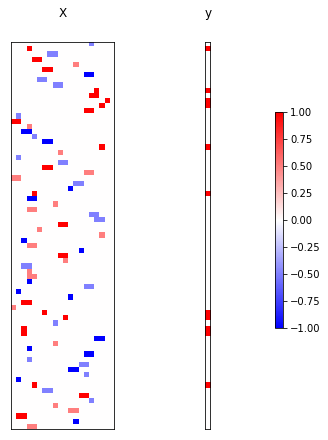

In [172]:
plot_named_tensors({'X': X, 'y': y})

## Exercise 1.2 Define a ConvNet architecture suitable for classifing your synthetic data


You are asked to define a 1D convolutional neural network with the following feed-forward architecture built from the [PyTorch modules](https://pytorch.org/docs/stable/nn.html) mentioned. The architecture should transform an input tensor $X \in \mathbb{R}^{N \times C \times W}$ into a vector of scalar activations $\mathbf{a} \in \mathbb{R}^{N \times 1}$. 

![image](img/conv1d_architecture.png)

Comments on the architecture:
* The *convolutional* layer is depicted as having exactly enough padding (implicitly zero) to ensure that the output feature maps have the same spatial length ($W=20$) as the input vector had. Notice that if you were to increase the filter size by 2, you need to increase the padding by 1 (padding appears on both ends) to keep the output of convolution the same length as before. See the documentation for the Conv1d module.
* The *max pooling* layer is being used here to take the maximum value across each of the 3 feature maps shown. Since we want to take the max over the entire spatial extent of the feature map, we use a large *kernel_size*.
* The 1-dimensional convolution and pooling operations require *spatial* data in $(N,C,W)$ format (where $W$ is the spatial dimension), so that the operators know how long the spatial dimension is. However the *linear* (fully-connected) layer doesn't know how to deal with spatial data, so the *flatten* operation simply reshapes the tensor from shape $(N,C,W)$ to shape $(N,D)$ where $D=C \times W$.
* Even though we'll use this architecture for binary classification, we do not add an extra *sigmoid* operation directly to the output. This is done for same reasons as for the multi-class PyTorch neural network from Lab 8. After the model is defined, we can still use it to predict binary class probabilities $\hat{y}_i \in [0,1]$ by feeding features $X$ through the model and then feeding the resulting activations $\mathbf{a}$ through a sigmoid so that class predictions are $\mathbf{\hat{y}} = \sigma(\mathbf{a})$. 

**Add a few lines of code** to define a PyTorch model with the above architecture.

## My note on < Comments on the architecture >:

* it depicts that it is the "same convolution". And the output size equation $out\_size = \lfloor \frac{n + 2 * p - f}{s} + 1 \rfloor$ where n is the input size (W in this example), p is the padding size, f is the filter size *(formulas from Coursera)*

* large *kernel_size* = $W$ in each channel

* torch.nn.Linear is a fully-connected Neural Network. It's better to have a torch.nn.flatten layer before a FC layer

* we don't need t add sigmoid on the output, Because it gives us an option of whether applying sigmoid or not apply depending on the problem we are trying to solve. If we are solving a regression problem, we need to apply softmax or sigmoid on the final output of the ConvNet; If we are trying to solve a classification problem, we can just use it to calculate the error and gradients.

Other notes:

A filter is same as 1 hidden unit in Conv1d layer. Increasing 1 filter allows 

In [173]:
torch.manual_seed(0) # Ensure model weights initialized with same random numbers

num_filter = 3   # The number of filters to learn
# My note: this is Exercise 1.3 asking to do. 
#          Comment this line when first reaching here
num_filter = 4
# My further note: we can try more filters than 4 if we don't want to use more num_epoch
# num_filter = 10

filter_size = 5  # The size of each filter

model = torch.nn.Sequential(
    # Your code for defining the model architecture here. Aim for 5-9 lines.
    torch.nn.Conv1d(in_channels=1, out_channels=num_filter, kernel_size=filter_size, stride=1, padding=filter_size//2),
    torch.nn.ReLU(),
    torch.nn.MaxPool1d(kernel_size=W),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=num_filter, out_features=1)
)

**Check your model architecture** by running the code cell below.

In [174]:
assert len(model) == 5, "Should be 5 layers!"
assert isinstance(model[0], torch.nn.Conv1d), "layer 0 should be Conv1d"
assert model[0].in_channels == C, "layer 0 should expect C input channel"
assert model[0].out_channels == num_filter, "layer 0 should expect %d output channels" % num_filter
assert model[0].kernel_size[0] == filter_size, "layer 0 filter size should be %d" % filter_size
assert model[0].padding[0] == filter_size//2
assert isinstance(model[1], torch.nn.ReLU), "layer 1 should be ReLU"
assert isinstance(model[2], torch.nn.MaxPool1d), "layer 2 should be MaxPool1d"
assert model[2].kernel_size == W, "layer 2 should pool over the entire input feature map"
assert isinstance(model[3], torch.nn.Flatten), "layer 3 should by Flatten"
assert isinstance(model[4], torch.nn.Linear), "layer 4 should be Linear"
assert model[4].in_features == num_filter, "layer 4 should have accept %d inputs" % num_filter
assert model[4].out_features == 1, "layer 4 should have only 1 output"
print("Looks OK!")

Looks OK!


**Plot your model's initial predictions** (i.e. *before* training) by running the code cell below. Notice that the untrained model predicts arbitrary class probabilies that all look similar. This is because the initial weights of the Conv1d and Linear layers are small random values, so the output is only weakly sensitive to the input.

tensor([[0.379],
        [0.357],
        [0.381],
        [0.338],
        [0.371]], grad_fn=<SliceBackward>)


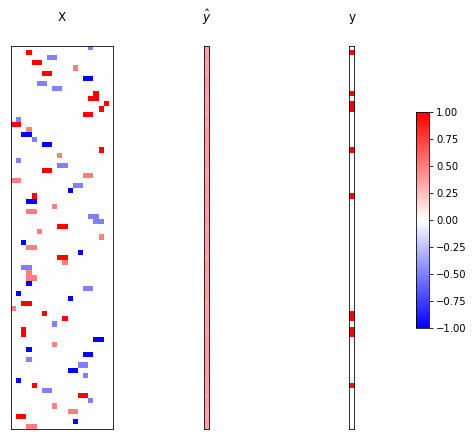

In [175]:
y_pred = torch.sigmoid(model(X))   # Turn activations into probabilities by feeding through sigmoid
print(y_pred[:5])                  # Print the first few probabilities
plot_named_tensors({'X': X, '$\hat{y}$': y_pred, 'y': y})

## Exercise 1.3 Train the ConvNet on your synthetic data

Here you should train the ConvNet architecture from Exercise 1.2, much as you trained a PyTorch neural network in Lab 8.

First, **run the code cell below** to make a copy of the untrained model from Exercise 1.2. This will make it easy to re-run the training code cell multiple times, each time starting from an untrained model (rather than continuing to train the same model!).

In [176]:
untrained_model = copy.deepcopy(model)

Next you'll need to define a loss function and implement the PyTorch training loop to train a copy of the untrained model. The PyTorch training loop for a ConvNet is identical to that of a neural network, so use Lab 8 as a guide.

However, for this exercise use the following configuration:
* *No mini-batches:* Unlike Lab 8, for this exercise do not use mini-batches. Instead feed the whole $X$ matrix through your model, like `model(X)` to get $N=75$ outputs. In other words, your training loop doesn't need an inner "mini-batch" loop.
* *Loss function:* Use the "binary cross entropy" loss that directly accepts activations ('logits'). In PyTorch this is implemented by the **[torch.nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCEWithLogitsLoss)** module. This is similar to the *CrossEntropyLoss* in Lab 8, except it's specialized to handle a single binary output.
* *Optimizer:* This is the learning algorithm. Use the **[torch.optim.SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)** optimizer with learning rate $0.05$, momentum $0.9$, and weight decay (weight penalty) of $0.001$.

Your training code should also print the current training loss for the first epoch and every 50 epochs after. The code for doing so is similar to in Lab 8. For example, if you computed your loss in variable `loss_value` then something like this would work:
```python
for epoch in range(1, num_epoch+1):
    
    ... your code to apply a step of gradient descent here
    
    if epoch == 1 or epoch % 50 == 0:
        print("Epoch %d had training loss %.4f" % (epoch, loss_value.item()))
```
where the `.item()` is a method that converts a scalar-valued PyTorch tensor into a standard Python value, like a *float*, so that it can be more easily formatted as part of the string.

The output of your training loop should look exactly like this:
```
Epoch 1 had training loss 0.8562
Epoch 50 had training loss 0.3519
Epoch 100 had training loss 0.3281
Epoch 150 had training loss 0.3212
...
```
However, the loss should not go to zero for the current model architecture. You'll fix that shortly.

In [178]:
# Start from a copy of the untrained model, so that when we re-run this code
# cell it always resets to the beginning.
model = copy.deepcopy(untrained_model)

# The number of times to evaluate the full training data (in this case, number of gradient steps)
num_epoch = 500
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.001)

# My note: this is where I changed the num_epoch
# num_epoch = 6 * num_epoch

# Your code for defining loss, optimizer, and training loop here. Aim for 10-12 lines.
# My note: go and see Lab 8 Exercise 2.2 (similar code)
for epoch in range(1, num_epoch+1):
    # feed-forward
    y_pred = model(X)
    loss_value = torch.nn.BCEWithLogitsLoss()(y_pred, y)
    # back-propagate
    model.zero_grad()          # reset all gradient accumulators to zero
    loss_value.backward()    # compute gradient of loss w.r.t. all parameters
    
    # My note: It is crucially different from defining optimizer inside the for-loop and defining outside of the for loop
#     torch.optim.SGD(params=model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.001).step()    # use the gradients to take a ste with SGD
    optimizer.step()
    
    # print loss for each 50 epoches
    if epoch == 1 or epoch % 50 == 0:
        print('Epoch %d had training loss %.4f' % (epoch, loss_value.item()))

Epoch 1 had training loss 0.5462
Epoch 50 had training loss 0.3510
Epoch 100 had training loss 0.2914
Epoch 150 had training loss 0.1697
Epoch 200 had training loss 0.0635
Epoch 250 had training loss 0.0318
Epoch 300 had training loss 0.0205
Epoch 350 had training loss 0.0153
Epoch 400 had training loss 0.0125
Epoch 450 had training loss 0.0107
Epoch 500 had training loss 0.0095


**Plot your trained model's predictions** in the code cell below. You should see that the prediction vector has an interesting pattern now (unlike the initial model), but that the predictions still do not quite match the targets.

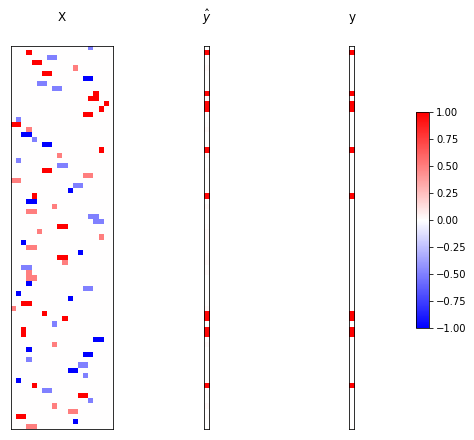

In [179]:
# Your code here. See Exercise 1.2.
y_pred = torch.sigmoid(model(X))
plot_named_tensors({'X': X, '$\hat{y}$': y_pred, 'y': y})

The mismatch between predictions and targets is why the loss did not get close to zero, despite the fact that your ConvNet architecture can, in principle, learn a perfect classifier.

If your model architecture was able to get the training loss to zero, the predictions would look more like this:

![image](img/synthetic_predictions.png)

<span style="color:red">Currently,  your ConvNet training got stuck in a local minimum!</span>
To give your ConvNet architecture a better chance at "getting lucky" and finding a path from random weights to useful weights, **try going back to Exercise 1.2 and increase the number of filters from 3 to 4**. You will then have to re-run all the code cells up to this point. With an extra filter, your ConvNet is now "lucky" enough to find at least one filter that detects a $0,1,0$ pattern.

## My Note:

And try to increase the *num_epoch* to **10 * num_epoch**, and see the results with 3 filters or 4 filters. Then we can figure out when the model with 4 filters descends really quickly when *num_epoch* = 10 * num_epoch, **however**, even when *num_epoch* = 20 * num_epoch, the model with 3 filters still feels struggled to descend.

**Reason:**

Because previously, I define the optimizer inside the for loop. After defining the optimizing outside of the for loop, it will be good without changing the *num_epoch*

## Advices from lab teacher:

we can also increase number of filters to do the same thing

## Exercise 1.4 Inspect the filters and weights of your ConvNet

Here you should visualize both the filter weights and the linear (fully-connected) weights. Use the *plot_matrix_grid* function. If you managed to get your training loss to be small (close to zero) then at least one of your filters should look like this:

![image](img/synthetic_filter_example.png)

where red means positive and blue means negative. When this filter is convolved with a sequence containing pattern $\ldots,0,1,0,\ldots$ it will "activate" and have a large output at the position centered on the $1$. That activation then gets selected by the max pooling operation, and is then used to activate the output of the network, giving correct classification.

**Write a few lines of plotting code** to visualize the weights of both layers. Do you see a correspondence between the filter that looks "right" and the positive weight(s) in the linear layer?

torch.Size([4, 1, 5])
torch.Size([1, 4])


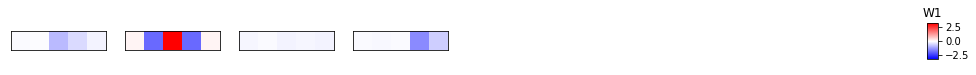

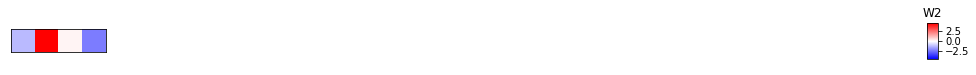

In [180]:
W1, b1, W2, b2 = model.parameters()
print(W1.shape)  # The tensor of 4 filters, each with 1 channel and kernel size 5
print(W2.shape)  # The matrix of linear (fully-connected) weights that combine the filter responses

# Your plotting code here. Aim for 2-4 lines of code.
# 1. plot the weights of the ConvNet
plot_matrix_grid(W1, cmap='bwr')
plt.title('W1')

# 2. plot the weights of the FC
# make 2d tensor W2 to 3d since plot_matrix_grid only accepts 3d array V
# print(W2[np.newaxis, :, :].shape)  # torch.Size([1, 1, 4])
plot_matrix_grid(W2[np.newaxis, :, :], cmap='bwr')
plt.title('W2');

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Digit classification with Convolutional Neural Networks

Exercise 2.1&ndash;2.2 expand on Lab 8, this time asking you to train a convolutional neural network on the MNIST data set rather than a fully-connected neural network.

## Exercise 2.1 Load and preprocess MNIST

**Implement the *load_mnist_for_convnet* function** below. Rather than normalizing the features with scikit-learn, perform a simple normalization by scaling the pixel intensities from range $[0,255]$ down to $[0,1]$. This will be good enough.

In [227]:
def load_mnist_for_convnet(filename):
    """
    Loads the MNIST data from a Numpy NPZ file and returns two PyTorch tensors:
    X: a float tensor with shape (N,1,28,28) where N is the number of images in the file
    y: an int64 tensor with shape (N,) containing the class targets for the images.
    The pixels values are scaled to be in range [0,1] where 0 is black and 1 is white.
    """
    # Your code here. Aim for 7-10 lines.
    # 1. read the data from the file
    with np.load(filename) as data:
        X = data['X']
        y = data['y']
#     print(X.shape, y.shape)  # (60000, 784) (60000,)
    
    # 2. normalize the pixel intensities
    num_cols = X.shape[1]
    scaler = np.ones((1, num_cols)) * 255
#     print(scaler.shape)   # (1, 784)
#     print(scaler)   # (255, 255, .. 255)
    X = X / scaler
    
    # 3. reshape X
    X = X.reshape(-1, 1, 28, 28)
    
    # 3. normalize the pixel intensities
#     for i in range(X.shape[0]):  # scan through each sample
# #         pixels = X[i, 0, :, :]
#         X[i, 0, :, :] = X[i, 0, :, :] / 255.0
    
    # 4. create tensors
    X = torch.tensor(X.astype(np.float32))
    y = torch.tensor(y.astype(np.int64))
    return X, y

X_train, y_train = load_mnist_for_convnet("mnist_train.npz")
X_test,  y_test  = load_mnist_for_convnet("mnist_test.npz")

**Check your answer** by running the code cell below.

In [228]:
assert isinstance(X_train, torch.FloatTensor), "Features should be float32!"
assert isinstance(y_train, torch.LongTensor), "Targets should be int64 or long!"
assert X_train.shape == (60000, 1, 28, 28), "X_train has wrong shape"
assert y_train.shape == (60000,), "y_train has wrong shape"
assert X_test.shape == (10000, 1, 28, 28), "X_test has wrong shape"
assert y_test.shape == (10000,), "y_test has wrong shape"
assert X_train.min() == 0 and X_train.max() == 1, "Features don't seem to be scaled right!"
print("Looks good!")

Looks good!


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 2.2 Train a Convolutional Neural Network on MNIST

You are asked to train a 2D ConvNet to classify MNIST digits. You'll need the *Conv2d* and *MaxPool2d* modules as described in the [PyTorch modules documentation](https://pytorch.org/docs/stable/nn.html). Your architecture will be similar to Part 1 of this lab, except rather than pooling over the entire input signal you will pool only over small 2x2 regions, preserving more spatial information for the subsequent linear (fully-connected) layer to use in classification.

**Write a few lines of code** to define a 2D ConvNet with the following feed-forward architecture:
1. Convolution with 8 filters each of size 5x5 and enough padding to ensure that each of the resulting feature maps has spatial dimensions 28x28, just like the input.
2. Rectified linear transformation (ReLU).
3. Max pooling with kernel size 2x2 and a non-overlapping stride (i.e. stride same as kernel size).
4. Flatten the spatial information
5. Linear (fully-connected) layer to use all the outputs of the max pooling layer as features to make a prediction.

(To predict class probabilities you'll have to apply a softmax function to the output, but that is normal in many deep learning frameworks because it makes training more numerically stable.)

Hint: the trickiest part 

In [229]:
torch.manual_seed(0) # Ensure model weights initialized with same random numbers

# Your code here. Aim for 8-11 lines.
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5, 5), padding=(2, 2)),  # filter is 2-dimensional (go and see Cousera deep learning course 4 week 1 Strided Convolutions
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(2, 2)),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=14*14*8, out_features=10)  # 10 digits, so 10 output units
#     torch.nn.Softmax()
)

**Check your model architecture** by trying to feed some inputs through. If an error is raised, then something is mis-configured in your network. The most likely error is that you did not correctly calculate the expected number of *in_features* for the linear layer, leading to a "size mismatch" in the tensors.

In [230]:
y_pred = model(X_train[:5])  # Check model architecture by trying to feed inputs through it.
assert y_pred.shape == (5, 10), "Expected a batch of 5 images to produce output of shape (5, 10)"

**Plot your initial model's predictions** on a the first 30 training inputs by running the code cell below. Notice that once again all the predictions are pretty much the same, and are far from the targets.

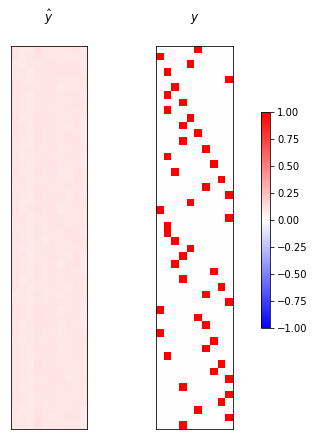

In [231]:
# Feed the model's predictions on 30 training cases through a row-wise softmax.
y_pred = torch.softmax(model(X_train[:50]), dim=1)

# Convert the first 30 training targets from index format {0,...,9} to a 1-hot format,
# for easier side-by-side comparison with the 10-dimensional output prediction.
y_true = torch.zeros((50, 10))
y_true[torch.arange(50), y_train[:50]] = 1

plot_named_tensors({'$\hat{y}$': y_pred, '$y$': y_true})

**Inspect your initial model's filters** by plotting them with the *plot_matrix_grid* function. They should look random and have small values roughly in range $[-0.1, 0.1]$ (Only plot the first layer filter weights, not the linear layer weights.) 


torch.Size([8, 1, 5, 5])
torch.Size([10, 1568])


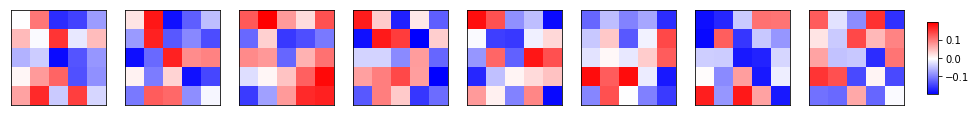

In [232]:
# Your plotting code here. Aim for 1-2 lines of code.
# print(model.parameters())
W1, b1, W2, b2 = model.parameters()
print(W1.shape)  # torch.Size([8, 1, 5, 5])
print(W2.shape)  # torch.Size([10, 1568])
plot_matrix_grid(W1[:, 0, :, :], cmap='bwr')

**Train your model** with the following configuration:
* Use the *CrossEntropyLoss* (since this is multi-class classification, not binary)
* Use the exact same optimizer configuration you used for Part 1 of this lab (learning rate $0.05$, etc).
* Use mini-batch training like you did in Lab 8, with a batch size of $100$.
* Train for 5 epochs (5 passes over the full training set)

First, define the loss function and optimizer in a separate code cell below:

In [233]:
# Your code to define loss function and optimizer here. Aim for 2 lines.
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.001)

Then, write your training loop in a separate code cell below, so that you can re-run this code cell to "continue" training with the same optimizer object, if you want to train your model longer.

I recommend you add a print statement to report progress like we did in Lab 8, such as:
```
Epoch 1 final minibatch had loss 0.2452
Epoch 2 final minibatch had loss 0.2077
...
```

In [239]:
# Your mini-batch training loop here. Aim for 9-12 lines.
# My note: this code cell is same as the Lab 8 code
num_epoch = 5
batch_size = 100
for epoch in range(num_epoch):
    
    # Make an entire pass (an 'epoch') over the training data in batch_size chunks
    for i in range(0, len(X_train), batch_size):
        X = X_train[i:i+batch_size]
        y = y_train[i:i+batch_size]
        
        y_pred = model(X)
        l = loss(y_pred, y)
        
        model.zero_grad()
        l.backward()
        optimizer.step()
    
    print("Epoch %d final minibatch had loss %.4f" % (epoch+1, l.item()))

Epoch 1 final minibatch had loss 0.1875
Epoch 2 final minibatch had loss 0.1881
Epoch 3 final minibatch had loss 0.1873
Epoch 4 final minibatch had loss 0.1878
Epoch 5 final minibatch had loss 0.1871


**The reason that the loss stucks at around 0.18 is:**

the model stucks at a local minima? But we have applied momentem=0.9 ?


**Plot your trained model's predictions**. The predictions should look different from before, and matching the targets better. 

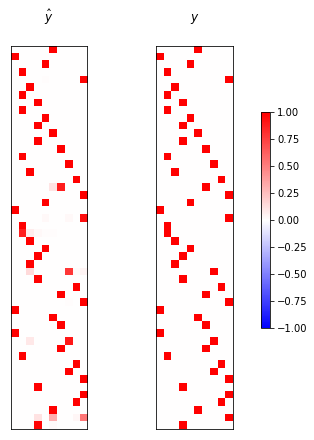

In [236]:
# Your code here. Aim for 2-3 lines. Re-use the y_true matrix from the earlier code cell.
y_pred = torch.softmax(model(X_train[:50]), dim=1)
plot_named_tensors({'$\hat{y}$': y_pred, '$y$': y_true})

If you only trained your ConvNet for 5 epochs total, you should be able to identify at least one training case that appears to be "harder" than the others, *i.e.* the model has a harder time giving a confident prediction. For example, here is an easy "9" and a hard "9" side by side:
![image](img/easy_and_hard.png)

**Plot an 'easy' training example and a 'hard' training example side-by-side** using the *plot_matrix_grid* function. This will require you to pull out two separate rows of *X_train* and turn them into a tensor with shape (2,28,28) so that the *plot_matrix_grid* knows what to plot.

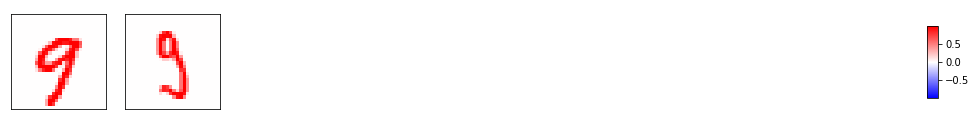

In [237]:
# You code here. Aim for 1-4 lines.
## previous answer
# plot_matrix_grid(X_train[[0, 1], :, :, :].reshape(2, 28, 28))
# print(X_train.shape)   # torch.Size([60000, 1, 28, 28])

## new answer
correct_classified = X_train[45]
wrong_classified = X_train[48]
plot_matrix_grid(torch.cat((correct_classified, wrong_classified)))

**Inspect your trained model's filters** by plotting them with the *plot_matrix_grid* function. They should no longer be completely random and instead contain structures that look like little "edge" detectors, such as the "diagonal line" detector shown below
![image](img/mnist_trained_filters.png)

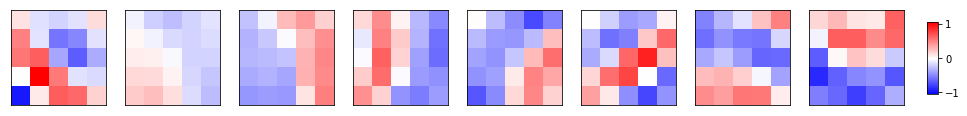

In [238]:
# Your code here. Aim for 2-3 lines.
W1, b1, W2, b2 = model.parameters()
plot_matrix_grid(W1[:, 0, :, :], cmap='bwr')